<a href="https://colab.research.google.com/github/ctjong27/Machine_Learning_Sandbox/blob/main/%232_COVID_Hackathon_Model_Submission_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Use Google Drive link to view a folder I shared with @columbia.edu google drive users
https://drive.google.com/drive/folders/18O-BnGOIw9ZiUwy17Uk_361xyfTF-qAN?usp=sharing
## 2. Right click folder and click "Add shortcut to Drive"
This will be sure the zipfile in this folder is accessible in your personal drive folder


In [1]:
# Connect to google drive
import os
from google.colab import drive
drive.mount('/content/drive')

# content in your drive is now available via "/content/drive/My Drive"


Mounted at /content/drive


In [2]:
# Import data and unzip files to folder
# !unzip /content/drive/MyDrive/Projects\ in\ Advanced\ Machine\ Learning/Week\ 7/covid_radiography_data/COVID-19_Radiography_Dataset.zip
!unzip /content/drive/MyDrive/Projects/COVID-19_Radiography_Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7933.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7934.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7935.png  
 

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)



print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]
[['COVID-19_Radiography_Dataset/COVID/images/COVID-1960.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-904.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2435.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-787.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2157.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1257.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3379.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-819.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1690.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1338.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3508.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-1990.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-617.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-3309.png', 'COVID-19_Radiography_Dataset/COVID/images/COVID-2410.png', 'COVID-19_Radiography_Dataset/COVID/images/COV

In [5]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator


image_gen = ImageDataGenerator(zoom_range=0.3)
# image_gen = ImageDataGenerator(rotation_range=45)

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        img = image_gen.random_transform(img) # apply random transformation

        return img



#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('COVID-19_Radiography_Dataset/COVID/images/COVID-2273.png').shape

(192, 192, 3)

In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
len(image_filepaths)

4032

In [9]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


4032
(4032, 192, 192, 3)
-0.0
1.0


In [10]:
len(fnames[2])

1344

In [11]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


COVID  NORMAL  PNEUMONIA
0         1       0          0
1         1       0          0
2         1       0          0
3         1       0          0
4         1       0          0
...     ...     ...        ...
4027      0       0          1
4028      0       0          1
4029      0       0          1
4030      0       0          1
4031      0       0          1

[4032 rows x 3 columns]

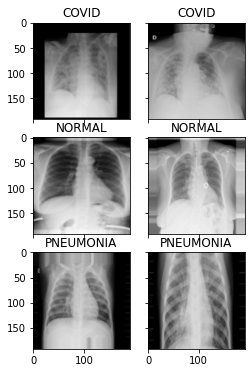

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor(fnames[0][0]) # COVID
im2 =preprocessor(fnames[0][1]) # COVID
im3 =preprocessor(fnames[1][0]) # NORMAL
im4 =preprocessor(fnames[1][1]) # NORMAL
im5 =preprocessor(fnames[2][0]) # PNEUMONIA
im6 =preprocessor(fnames[2][1]) # PNEUMONIA

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

labels = ['COVID', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA']
# for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # Iterating over the grid returns the Axes.
for i, (ax, im) in enumerate(zip(grid, [im1, im2, im3, im4, im5, im6])):
    ax.imshow(im)
    # ax.set_title(f"{labels[i]}: Image {i+1}")
    ax.set_title(f"{labels[i]}")
  
plt.show()

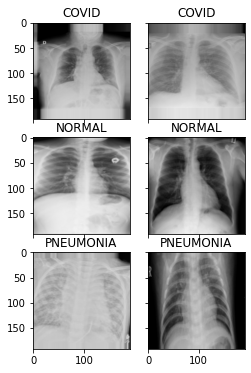

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

# im1 =preprocessor(fnames[0][0]) # COVID
# im2 =preprocessor(fnames[0][1]) # COVID
# im3 =preprocessor(fnames[1][0]) # NORMAL
# im4 =preprocessor(fnames[1][1]) # NORMAL
# im5 =preprocessor(fnames[2][0]) # PNEUMONIA
# im6 =preprocessor(fnames[2][1]) # PNEUMONIA

im1 =preprocessor(fnames[0][3]) # COVID
im2 =preprocessor(fnames[0][4]) # COVID
im3 =preprocessor(fnames[1][3]) # NORMAL
im4 =preprocessor(fnames[1][4]) # NORMAL
im5 =preprocessor(fnames[2][3]) # PNEUMONIA
im6 =preprocessor(fnames[2][4]) # PNEUMONIA

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

labels = ['COVID', 'COVID', 'NORMAL', 'NORMAL', 'PNEUMONIA', 'PNEUMONIA']
# for ax, im in zip(grid, [im1, im2, im3, im4, im5, im6]):
    # Iterating over the grid returns the Axes.
for i, (ax, im) in enumerate(zip(grid, [im1, im2, im3, im4, im5, im6])):
    ax.imshow(im)
    # ax.set_title(f"{labels[i]}: Image {i+1}")
    ax.set_title(f"{labels[i]}")
  
plt.show()

In [14]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)


X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [15]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [16]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle

# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)

#Save data
import pickle

# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)

#Save data
import pickle

# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [17]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

In [ ]:
#########################################
############## model 1 ##################
#########################################

import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=9, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=9, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=9, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=9, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=9, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

model.save("model1.h5", save_format="h5")


Epoch 1/5
69/69 [==============================] - 39s 307ms/step - loss: 1.2474 - accuracy: 0.3481 - val_loss: 1.0985 - val_accuracy: 0.3388
Epoch 2/5
69/69 [==============================] - 17s 249ms/step - loss: 1.1288 - accuracy: 0.3358 - val_loss: 1.0963 - val_accuracy: 0.3206
Epoch 3/5
69/69 [==============================] - 17s 250ms/step - loss: 1.0963 - accuracy: 0.3558 - val_loss: 1.0988 - val_accuracy: 0.3206
Epoch 4/5
69/69 [==============================] - 18s 254ms/step - loss: 1.0993 - accuracy: 0.3526 - val_loss: 1.0916 - val_accuracy: 0.3406
Epoch 5/5
69/69 [==============================] - 18s 254ms/step - loss: 1.5277 - accuracy: 0.3850 - val_loss: 1.1020 - val_accuracy: 0.3206


In [18]:
#########################################
############## model 2 ##################
#########################################

import tensorflow as tf
from tensorflow.keras.applications import VGG16


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.


  # Load the VGG16 model
  base_model = VGG16(input_shape=(192, 192, 3), include_top=False, weights='imagenet')
  base_model.trainable = False
  # base_model.summary()

  model = tf.keras.Sequential([
    base_model,
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

model.save("model2.h5", save_format="h5")


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
69/69 [==============================] - 32s 209ms/step - loss: 1.0078 - accuracy: 0.4320 - val_loss: 0.7146 - val_accuracy: 0.6193
Epoch 2/5
69/69 [==============================] - 10s 139ms/step - loss: 0.6911 - accuracy: 0.6359 - val_loss: 0.6900 - val_accuracy: 0.6721
Epoch 3/5
69/69 [==============================] - 10s 140ms/step - loss: 0.5031 - accuracy: 0.7810 - val_loss: 0.4988 - val_accuracy: 0.7814
Epoch 4/5
69/69 [==============================] - 9s 127ms/step - loss: 0.3873 - accuracy: 0.8472 - val_loss: 0.4081 - val_accuracy: 0.8288
Epoch 5/5
69/69 [==============================] - 9s 129ms/step - loss: 0.3576 - accuracy: 0.8650 - val_loss: 0.3119 - val_accuracy: 0.8652


In [ ]:
#########################################
############## model 3 ##################
#########################################

import tensorflow as tf

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    # tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(kernel_size=1, filters=64, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    # tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(kernel_size=1, filters=128, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    # tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    # tf.keras.layers.MaxPooling2D(pool_size=2),
    # tf.keras.layers.Conv2D(kernel_size=3, filters=512, padding='same', activation='relu'),
    # tf.keras.layers.Conv2D(kernel_size=1, filters=512, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_split=.2) #, callbacks=[red_lr]) for callback that automatically adjusts lr

model.save("model3.h5", save_format="h5")


Epoch 1/5
69/69 [==============================] - 4s 48ms/step - loss: 5.4073 - accuracy: 0.5926 - val_loss: 0.5908 - val_accuracy: 0.7140
Epoch 2/5
69/69 [==============================] - 3s 46ms/step - loss: 0.5926 - accuracy: 0.7272 - val_loss: 0.5710 - val_accuracy: 0.7450
Epoch 3/5
69/69 [==============================] - 3s 48ms/step - loss: 0.4721 - accuracy: 0.7929 - val_loss: 0.5064 - val_accuracy: 0.7760
Epoch 4/5
69/69 [==============================] - 3s 45ms/step - loss: 0.3621 - accuracy: 0.8508 - val_loss: 0.5495 - val_accuracy: 0.7614
Epoch 5/5
69/69 [==============================] - 3s 48ms/step - loss: 0.2698 - accuracy: 0.8978 - val_loss: 0.5941 - val_accuracy: 0.7523


In [ ]:
# #########################################
# ############## model 4 ##################
# #########################################



# import tensorflow as tf
# from sklearn.model_selection import GridSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# def create_model(num_filters, kernel_size, learning_rate):
#     model = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(kernel_size=kernel_size, filters=num_filters, padding='same', activation='relu', input_shape=(192, 192, 3)),
#         tf.keras.layers.Conv2D(kernel_size=1, filters=num_filters, padding='same', activation='relu'),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(3, activation='softmax')
#     ])
#     optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# model = KerasClassifier(build_fn=create_model, verbose=1)

# param_grid = {
#     'num_filters': [32],
#     'kernel_size': [3],
#     'learning_rate': [0.001, 0.0001],
#     'epochs': [3],
#     'verbose': [1],
#     'validation_split': [0.1, 0.2]
# }

# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# grid_result = grid.fit(X_train, y_train)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [20]:
# Begin to submit models to image classification leaderboard
! pip install aimodelshare --upgrade
# Restart session Runtime > Restart runtime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 967.8/967.8 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 KB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 KB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.4/28.4 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/

In [21]:
# Save preprocessor function (may need to reload function in cell above)
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

# Save tf.keras model (or any tensorflow model) to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx


Your preprocessor is now saved to 'preprocessor.zip'


In [22]:
#Use X_test data to generate model predictions and make leaderboard submission

#Generate and save predictions

#Load preprocessed data
#If you run out of Colab memory restart runtime, reload data and try again
import pickle
  
# Open the file in binary mode
with open('X_test.pkl', 'rb') as file:
    # Call load method to deserialze
    X_test = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)
    
prediction_column_index=model.predict(X_test).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
41/41 [==============================] - 7s 146ms/step


In [ ]:

# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model1.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'
3
import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

# Submit Model 1 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      7808      
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        165952    
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                    

In [23]:

# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model2.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=True,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

# Submit Model 2 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 32)          147488    
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          1056      
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 64)          4160      
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 128)         1

In [ ]:

# Reload model and data
import tensorflow as tf
model = tf.keras.models.load_model('model3.h5',compile=False)
model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

onnx_model = model_to_onnx(model, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

apiurl='https://bb4mkgq8sb.execute-api.us-east-2.amazonaws.com/prod/m'

import aimodelshare as ai
experiment= ai.Experiment(apiurl)

from aimodelshare.aws import set_credentials
set_credentials(apiurl=apiurl)

# Submit Model 3 to Competition Leaderboard
experiment.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 192, 192, 32)      896       
                                                                 
 conv2d_21 (Conv2D)          (None, 192, 192, 32)      1056      
                                                                 
 flatten_2 (Flatten)         (None, 1179648)           0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3538947   
                                                                 
Total params: 3,540,899
Trainable params: 3,540,899
Non-trainable params: 0
_________________________________________________________________
AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.
Insert search tags to help users find your model (optiona

In [ ]:

data = experiment.get_leaderboard()
experiment.stylize_leaderboard(data)